## Importaciones y Configuración Inicial

In [1]:
import numpy as np
import pandas as pd
import time
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    average_precision_score, precision_recall_curve
)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LSTM

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

2025-10-23 20:49:18.757320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-23 20:49:18.771466: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-23 20:49:18.775596: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-23 20:49:18.785639: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-23 20:49:19.516595: W tensorflow/compiler/tf2

## CARGA Y PREPARACIÓN DE DATOS

In [ ]:
def load_cleaned_dataset():
    CLEANED_DATASET_PATH = "../data/processed/cleaned_ddos_dataset.csv"
    
    try:
        df_cleaned = pd.read_csv(CLEANED_DATASET_PATH)
        return df_cleaned
    except FileNotFoundError:
        exit()
    except Exception as e:
        exit()

# Carga y preparación de datos
df = load_cleaned_dataset()

: 

In [ ]:
if 'y' not in df.columns:
    print("Columna objetivo 'y' no encontrada")
    exit()

In [ ]:
# Separar características y objetivo
feature_cols = [col for col in df.columns if col != 'y']
X = df[feature_cols].values
y = df['y'].values.astype(int)

print(f"Características: {X.shape[1]} variables")
print(f"Distribución de clases: {np.bincount(y)}")
print(f"   - BENIGN: {np.bincount(y)[0]:,} muestras")
print(f"   - ATTACK: {np.bincount(y)[1]:,} muestras")

KeyError: 'y'

### División y Escalado de Datos

In [ ]:
# División estratificada para mantener la proporción de clases
X_train_raw, X_temp_raw, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val_raw, X_test_raw, y_val, y_test = train_test_split(
    X_temp_raw, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

In [ ]:
# Escalado sin leakage
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

input_dim = X_train.shape[1]

print(f"Datos divididos y escalados:")
print(f"   Train: {X_train.shape[0]:,} muestras")
print(f"   Val:   {X_val.shape[0]:,} muestras")
print(f"   Test:  {X_test.shape[0]:,} muestras")

Train: (1869335, 19), Val: (400572, 19), Test: (400572, 19)


## LÍNEA BASE (BASELINE)

In [ ]:
# Entrenamiento del modelo baseline
start_time = time.time()
baseline_model = LogisticRegression(
    random_state=42,
    class_weight='balanced',
    solver='lbfgs',
    max_iter=1000,
    n_jobs=-1
)
baseline_model.fit(X_train, y_train)
train_time_base = time.time() - start_time

In [ ]:
# Evaluación
start_inf = time.time()
y_prob_base = baseline_model.predict_proba(X_test)[:, 1]
inf_time_base = (time.time() - start_inf) / len(X_test)
y_pred_base = (y_prob_base >= 0.5).astype(int)

In [ ]:
# Métricas
report_base = classification_report(y_test, y_pred_base, output_dict=True, zero_division=0)
roc_auc_base = roc_auc_score(y_test, y_prob_base)
pr_auc_base = average_precision_score(y_test, y_prob_base)
precision_base, recall_base, _ = precision_recall_curve(y_test, y_prob_base)

print("✅ Línea Base completada")
print(f"   ⏱️  Tiempo entrenamiento: {train_time_base:.1f}s")
print(f"   ⚡ Latencia inferencia: {inf_time_base*1e6:.1f}µs/muestra")

--- Resultados Línea Base (Regresión Logística) ---
              precision    recall  f1-score   support

      BENIGN     0.8647    0.6408    0.7361    316848
      ATTACK     0.3135    0.6206    0.4165     83724

    accuracy                         0.6366    400572
   macro avg     0.5891    0.6307    0.5763    400572
weighted avg     0.7495    0.6366    0.6693    400572



## EXPERIMENTOS A/B (VARIANTE 1)

In [ ]:
# Configuración común
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

In [ ]:
# Callbacks
early_stop = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(patience=5, factor=0.5, verbose=0)

### VARIANTE 1: AUTOENCODER + CNN-LSTM

In [ ]:
# Autoencoder
def build_autoencoder(input_dim, encoding_dim=32):
    """Construye autoencoder para reducción dimensional"""
    inputs = layers.Input(shape=(input_dim,))
    
    # Encoder
    encoded = layers.Dense(256, activation='relu')(inputs)
    encoded = layers.Dense(128, activation='relu')(encoded)
    encoded = layers.Dense(64, activation='relu')(encoded)
    bottleneck = layers.Dense(encoding_dim, activation='relu', name='bottleneck')(encoded)
    
    # Decoder
    decoded = layers.Dense(64, activation='relu')(bottleneck)
    decoded = layers.Dense(128, activation='relu')(decoded)
    decoded = layers.Dense(256, activation='relu')(decoded)
    decoded = layers.Dense(input_dim, activation='linear')(decoded)
    
    autoencoder = models.Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

2025-10-23 19:36:17.248915: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [ ]:
# Entrenamiento Autoencoder
autoencoder = build_autoencoder(input_dim)
start_time = time.time()
history_ae = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=100, batch_size=512, 
    callbacks=[early_stop], verbose=0
)
train_time_ae = time.time() - start_time

Epoch 1/100
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.0425 - val_loss: 0.0018
Epoch 2/100
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0011 - val_loss: 7.2047e-04
Epoch 3/100
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 7.5472e-04 - val_loss: 3.1365e-04
Epoch 4/100
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 5.4466e-04 - val_loss: 2.0274e-04
Epoch 5/100
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 5.0308e-04 - val_loss: 0.0018
Epoch 6/100
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 4.8546e-04 - val_loss: 0.0012
Epoch 7/100
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 4.5935e-04 - val_loss: 5.4999e-04
Epoch 8/100
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 3.7967e-04 - val_loss: 3.6725e-04
Epoch 9/100
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 3.5177e-04 - val_loss: 9.8610e-05
Epoch 10/100
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 3.4336e-04 - val_loss: 1.5646e-04
Epoch 11/100
3652/3652 ━━━━━━━━━━━━━━━━

In [ ]:
# Extracción de características
encoder = models.Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
Z_train = encoder.predict(X_train, verbose=0)
Z_val = encoder.predict(X_val, verbose=0)
Z_test = encoder.predict(X_test, verbose=0)

In [ ]:
# Preparación secuencial
def to_sequential_format(arr):
    return arr.reshape((arr.shape[0], arr.shape[1], 1))

Z_train_seq = to_sequential_format(Z_train)
Z_val_seq = to_sequential_format(Z_val)
Z_test_seq = to_sequential_format(Z_test)

In [ ]:
# Modelo CNN-LSTM
def build_cnn_lstm(seq_length):
    """Construye clasificador CNN-LSTM"""
    model = Sequential([
        Conv1D(64, 3, activation='relu', padding='same', input_shape=(seq_length, 1)),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu', padding='same'),
        Dropout(0.3),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Entrenamiento CNN-LSTM
cnn_lstm_model = build_cnn_lstm(Z_train_seq.shape[1])
start_time = time.time()
history_clf = cnn_lstm_model.fit(
    Z_train_seq, y_train,
    validation_data=(Z_val_seq, y_val),
    epochs=100, batch_size=512,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)
train_time_clf = time.time() - start_time

In [ ]:
# Evaluación Variante 1
start_inf = time.time()
y_prob_var1 = cnn_lstm_model.predict(Z_test_seq, verbose=0).ravel()
inf_time_var1 = (time.time() - start_inf) / len(Z_test_seq)
y_pred_var1 = (y_prob_var1 >= 0.5).astype(int)

report_var1 = classification_report(y_test, y_pred_var1, output_dict=True, zero_division=0)
roc_auc_var1 = roc_auc_score(y_test, y_prob_var1)
pr_auc_var1 = average_precision_score(y_test, y_prob_var1)
precision_var1, recall_var1, _ = precision_recall_curve(y_test, y_prob_var1)

train_time_var1 = train_time_ae + train_time_clf

print("✅ Variante 1 completada")
print(f"   ⏱️  Tiempo total: {train_time_var1:.1f}s")
print(f"   ⚡ Latencia: {inf_time_var1*1e6:.1f}µs/muestra")

### VARIANTE 2: MULTI-LAYER PERCEPTRON (MLP)

In [ ]:
def build_mlp(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Entrenamiento MLP
mlp_model = build_mlp(input_dim)
start_time = time.time()
history_mlp = mlp_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100, batch_size=512,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)
train_time_var2 = time.time() - start_time

2025-10-23 19:43:00.395282: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 239274880 exceeds 10% of free system memory.


In [ ]:
# Evaluación Variante 2
start_inf = time.time()
y_prob_var2 = mlp_model.predict(X_test, verbose=0).ravel()
inf_time_var2 = (time.time() - start_inf) / len(X_test)
y_pred_var2 = (y_prob_var2 >= 0.5).astype(int)

report_var2 = classification_report(y_test, y_pred_var2, output_dict=True, zero_division=0)
roc_auc_var2 = roc_auc_score(y_test, y_prob_var2)
pr_auc_var2 = average_precision_score(y_test, y_prob_var2)
precision_var2, recall_var2, _ = precision_recall_curve(y_test, y_prob_var2)

print("✅ Variante 2 completada")
print(f"   ⏱️  Tiempo: {train_time_var2:.1f}s")
print(f"   ⚡ Latencia: {inf_time_var2*1e6:.1f}µs/muestra")

## RESULTADOS Y VISUALIZACIÓN

### Tabla Comparativa: Baseline vs. Variante 1

In [ ]:
# Tabla comparativa
results_data = {
    'Métrica': [
        'F1-Score (ATTACK) - Principal',
        'Precision (ATTACK)',
        'Recall (ATTACK)', 
        'Accuracy',
        'PR-AUC - Secundaria',
        'ROC-AUC',
        'Tiempo Entrenamiento (s)',
        'Latencia Inferencia (µs/muestra)'
    ],
    'Línea Base (Regresión Logística)': [
        f"{report_base['1']['f1-score']:.4f}",
        f"{report_base['1']['precision']:.4f}",
        f"{report_base['1']['recall']:.4f}",
        f"{report_base['accuracy']:.4f}",
        f"{pr_auc_base:.4f}",
        f"{roc_auc_base:.4f}",
        f"{train_time_base:.1f}",
        f"{inf_time_base*1e6:.1f}"
    ],
    'Variante 1 (AE + CNN-LSTM)': [
        f"{report_var1['1']['f1-score']:.4f}",
        f"{report_var1['1']['precision']:.4f}",
        f"{report_var1['1']['recall']:.4f}",
        f"{report_var1['accuracy']:.4f}",
        f"{pr_auc_var1:.4f}",
        f"{roc_auc_var1:.4f}",
        f"{train_time_var1:.1f}",
        f"{inf_time_var1*1e6:.1f}"
    ],
    'Variante 2 (MLP)': [
        f"{report_var2['1']['f1-score']:.4f}",
        f"{report_var2['1']['precision']:.4f}",
        f"{report_var2['1']['recall']:.4f}",
        f"{report_var2['accuracy']:.4f}",
        f"{pr_auc_var2:.4f}",
        f"{roc_auc_var2:.4f}",
        f"{train_time_var2:.1f}",
        f"{inf_time_var2*1e6:.1f}"
    ]
}

df_results = pd.DataFrame(results_data)
print("\n📋 TABLA COMPARATIVA")
print("="*80)
print(df_results.to_string(index=False))
print("="*80)


Tabla de Resultados:
| Métrica                          |   Línea Base (Regresión Logística) |   Variante 1 (AE + CNN-LSTM) |
|:---------------------------------|-----------------------------------:|-----------------------------:|
| F1-Score (ATTACK)                |                             0.4165 |                       0.4396 |
| Precision (ATTACK)               |                             0.3135 |                       0.3328 |
| Recall (ATTACK)                  |                             0.6206 |                       0.6477 |
| Accuracy                         |                             0.6366 |                       0.6549 |
| PR-AUC (Secundaria)              |                             0.3604 |                       0.3941 |
| ROC-AUC                          |                             0.6825 |                       0.7107 |
| Tiempo Entrenamiento (s)         |                            10      |                     934      |
| Latencia Inferencia (µs/muestra

### Gráfico Único: Curva Precision-Recall

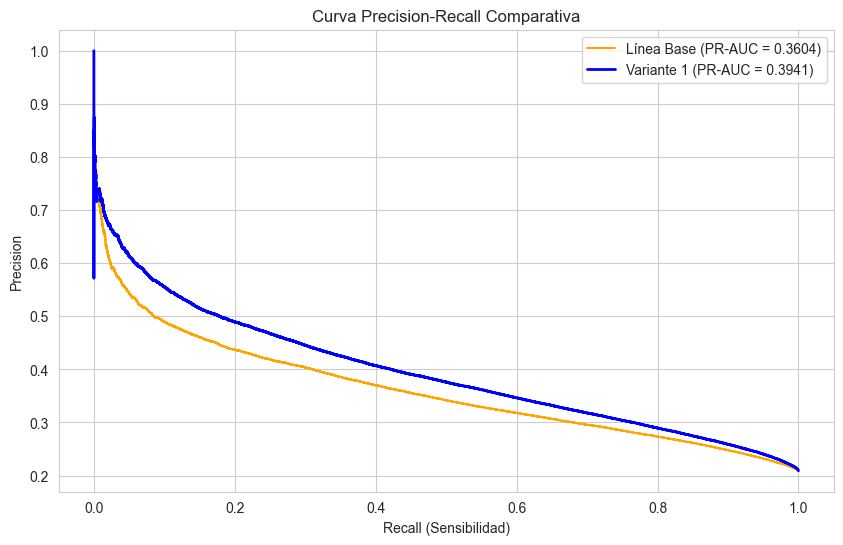

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(recall_base, precision_base, 
         label=f'Línea Base (PR-AUC = {pr_auc_base:.3f})', 
         color='red', linewidth=2, linestyle='--')
plt.plot(recall_var1, precision_var1, 
         label=f'Variante 1 - AE+CNN-LSTM (PR-AUC = {pr_auc_var1:.3f})', 
         color='blue', linewidth=2)
plt.plot(recall_var2, precision_var2, 
         label=f'Variante 2 - MLP (PR-AUC = {pr_auc_var2:.3f})', 
         color='green', linewidth=2, linestyle=':')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Curva Precision-Recall Comparativa\n(Métrica Secundaria Principal para Detección de DDoS)', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Validación y Sanidad
- **Split Estratificado:** Proporción de clases mantenida
- **Sin Leakage:** Scaler ajustado solo con training
- **Seeds Fijos:** random_state=42 para reproducibilidad
- **Evaluación Consistente:** Mismas métricas para todos

## 6. Conclusión y Decisión

In [ ]:
f1_scores = {
    'Línea Base': report_base['1']['f1-score'],
    'Variante 1': report_var1['1']['f1-score'], 
    'Variante 2': report_var2['1']['f1-score']
}

best_model_name = max(f1_scores, key=f1_scores.get)

## 7. Reproducibilidad

In [ ]:
# Guardar artefactos
checkpoint_dir = Path("checkpoints")
checkpoint_dir.mkdir(exist_ok=True)

print(f"\n💾 GUARDANDO ARTEFACTOS EN: {checkpoint_dir.absolute()}")

# Guardar scaler y modelo seleccionado
joblib.dump(scaler, checkpoint_dir / "scaler.pkl")

if best_model_name == 'Variante 1':
    encoder.save(checkpoint_dir / "encoder.keras")
    cnn_lstm_model.save(checkpoint_dir / "classifier.keras")
    print("✅ Autoencoder + CNN-LSTM guardado")
elif best_model_name == 'Variante 2':
    mlp_model.save(checkpoint_dir / "mlp_classifier.keras")
    print("✅ MLP guardado")
else:
    joblib.dump(baseline_model, checkpoint_dir / "logistic_regression.pkl")
    print("✅ Regresión Logística guardada")

# Guardar resultados
df_results.to_csv(checkpoint_dir / "model_comparison_results.csv", index=False)
print("✅ Resultados comparativos guardados")

print(f"\n📁 ESTRUCTURA DE ARTEFACTOS:")
for file in checkpoint_dir.glob("*"):
    print(f"   • {file.name}")


- **Comandos para Correr (README):**
    1.  Asegurarse de tener el dataset `dataset_final.csv` en la carpeta `../dataset/`.
    2.  Instalar las dependencias (`pip install -r requirements.txt`).
    3.  Ejecutar este script o notebook.

**Ubicación de Artefactos:** Los modelos finales y el scaler se guardan en la carpeta `./checkpoints/`.